In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import yaml
from hy2dl.modelzoo import get_model
from hy2dl.utils.config import Config
from hy2dl.utils.utils import set_random_seed
from tqdm import trange
from utilities.data import DataHandler
from utilities.postprocessing import Postprocessor
from utilities.training import Trainer

### Part 1. Setup

In [2]:
# Load configuration
config = yaml.safe_load(open("files/camels_gb.yml"))

# Modify configuration
config["experiment_name"] = "CAMELS-GB_LSTM-064_NSE"
config["path_save_folder"] = "results/run_LSTM"
config["model"] = "CudaLSTM"

# Convert into 'Config' object
config = Config(config)

Folder 'results\run_LSTM' was created to store the results.


### Part 2. Load data

In [3]:
# Get data
handler_data = DataHandler(config)
handler_data.load_data()

basin_ids = handler_data.get_basin_ids()

loader_training = handler_data.get_loader("training")
loader_validation = handler_data.get_loader("validation")
dataloaders = {
    "training": loader_training,
    "validation": loader_validation
}

2025-08-29 14:55:02 - Loading data from CAMELS_GB dataset...
2025-08-29 14:55:02 - Loading training data...


Processing entities: 100%|##########| 7/7 [00:00<00:00, 26.79entity/s]


2025-08-29 14:55:02 - Loading validation data...


Processing entities: 100%|##########| 3/3 [00:00<00:00, 35.39entity/s]


2025-08-29 14:55:02 - Basins without valid samples in period of interest: ['18014']
2025-08-29 14:55:02 - Number of valid samples
2025-08-29 14:55:02 -    Training:      36,260
2025-08-29 14:55:02 -    Validation:     2,926
2025-08-29 14:55:02 - Time required to process load data: 0:00:00
2025-08-29 14:55:02 - -------------------- Details DataLoader --------------------
2025-08-29 14:55:02 -              Key              |            Shape             
2025-08-29 14:55:10 - x_d
2025-08-29 14:55:10 -         precipitation         |    torch.Size([256, 730])    
2025-08-29 14:55:10 -              peti             |    torch.Size([256, 730])    
2025-08-29 14:55:10 -          temperature          |    torch.Size([256, 730])    
2025-08-29 14:55:10 - x_s                           |    torch.Size([256, 22])     
2025-08-29 14:55:10 - y_obs                         |  torch.Size([256, 365, 1])   
2025-08-29 14:55:10 - x_d_conceptual
2025-08-29 14:55:10 -         precipitation         |    tor

### Part 3. Model

In [4]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

### Part 4. Training

In [5]:
# Start trainer
handler_training = Trainer(config, dataloaders, model)

# Get list of learning rates
num_epochs = config.epochs

lrs = list(range(1, num_epochs + 1))
lrs = [config.learning_rate[max(k for k in config.learning_rate if k <= num)] for num in lrs]

In [7]:
# Start training and report
config.logger.info("Starting training")
config.logger.info(f"{'':^5} | {'':^8} | {'Trainining':^30} | {'Validation':^30} |")
config.logger.info(f"{'Epoch':^5} | {'LR':^8} | {'Loss':^8} | {'NSE':^8} | {'Time':^8} | {'Loss':^8} | {'NSE':^8} | {'Time':^8} |")

time_training = time.time()
for epoch in trange(num_epochs, desc="Epochs", ncols=78, ascii=True, unit="epoch", leave=False):
    # Set learning rate
    handler_training.optimizer.update_optimizer_lr(epoch=(epoch + 1))

    # Train
    loss_train, time_train = handler_training.run_epoch("training")
    if (epoch + 1) % config.validate_every != 0:
        config.logger.info(f"{epoch + 1:^5} | {lrs[epoch]:^8.1e} | {loss_train:^8.4f} | {0.44:^8.4f} | {time_train:^8} | {'':^8} | {'':^8} | {'':^8} |")
        continue
    
    # Validate
    loss_val, time_val = handler_training.run_epoch("validation")
    config.logger.info(f"{epoch + 1:^5} | {lrs[epoch]:^8.1e} | {loss_train:^8.4f} | {0.44:^8.4f} | {time_train:^8} | {loss_val:^8.4f} | {0.88:^8.4f} | {time_val:^8} |")

# Finish training
time_training = str(datetime.timedelta(seconds=int(time.time() - time_training)))
config.logger.info("Run completed successfully")
config.logger.info(f"Total run time: {time_training}")

2025-08-29 14:55:37 - Starting training
2025-08-29 14:55:37 -       |          |           Trainining           |           Validation           |
2025-08-29 14:55:37 - Epoch |    LR    |   Loss   |   NSE    |   Time   |   Loss   |   NSE    |   Time   |


Epochs:  25%|#######7                       | 1/4 [01:41<05:03, 101.24s/epoch]

2025-08-29 14:57:18 -   1   | 1.0e-03  |  0.0593  |  0.4400  | 0:01:41  |          |          |          |


Epochs:  50%|###############5               | 2/4 [03:31<03:32, 106.33s/epoch]

2025-08-29 14:59:08 -   2   | 1.0e-03  |  0.0326  |  0.4400  | 0:01:37  |  1.5021  |  0.8800  | 0:00:12  |


Epochs:  75%|#######################2       | 3/4 [05:13<01:44, 104.66s/epoch]

2025-08-29 15:00:51 -   3   | 1.0e-03  |  0.0273  |  0.4400  | 0:01:42  |          |          |          |


2025-08-29 15:02:45 -   4   | 1.0e-03  |  0.0241  |  0.4400  | 0:01:42  |  1.4725  |  0.8800  | 0:00:11  |
2025-08-29 15:02:45 - Run completed successfully
2025-08-29 15:02:45 - Total run time: 0:07:08


### Part 5. Postprocess model

In [8]:
handler_postprocessing = Postprocessor(config)
results = handler_postprocessing.postprocess(model)

2025-08-29 15:02:57 - Loading testing data...
2025-08-29 15:02:58 - Testing data loaded in 0:00:00


Basins: 100%|################################| 7/7 [01:19<00:00, 11.41s/basin]


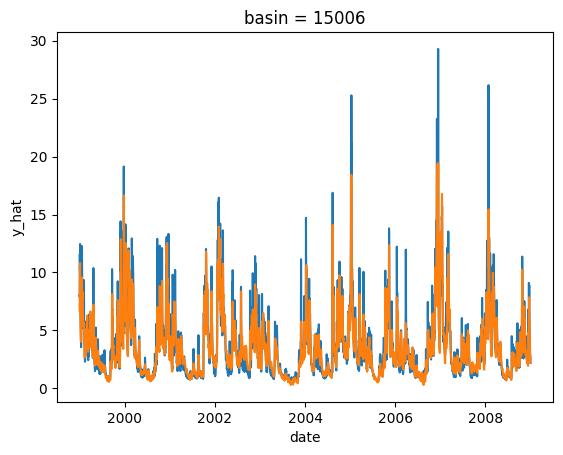

In [9]:
fig, ax = plt.subplots()
results.sel(basin="15006").y_obs.plot(ax=ax, label="Observed", color="tab:blue")
results.sel(basin="15006").y_hat.plot(ax=ax, label="Predicted", color="tab:orange")
plt.show()